In [207]:
import numpy as np
import pandas as pd
from pathlib import Path
from PIL import Image
import nibabel as nib
import matplotlib.pyplot as plt
import csv

# Torch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, Subset
from torchvision.transforms import functional as TF
import torch.nn.init as init
from torchsummary import summary

# Image preprocessing
from skimage.transform import resize

# Model and training utilities
import segmentation_models_pytorch as smp
from sklearn.model_selection import train_test_split

# Setup
import logging
import pickle 
import argparse

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
dir = Path("/work3/kvabo/PKGCTORG/newCT")

import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr
from sklearn.metrics import mean_absolute_error

In [32]:
nCase = 0
targetClass = 1

qcDirLiver = Path( "/work3/kvabo/predictions/qcLiverDsc1.0")
df = pd.read_csv(qcDirLiver /"resultsUpdate.csv")
liverSlices = df[(df["case"] == nCase)]

gtSeg0 = np.load(dir / f"labels-{0}.npy")
ct_path = dir / f"volume-{0}.npy"
Z = []
YHat = []
YZHat = []

n_total_slices = gtSeg0.shape[2]

# Preallocate volume of zeros
pred = np.zeros((512, 512, n_total_slices), dtype=np.float32)


for slice in range(n_total_slices):
    liverMask = np.zeros((512, 512), dtype=np.uint8)

    if slice in liverSlices["slice"].values:
        # Load predicted segmentation
        segPathLiver = qcDirLiver / f"{0}_slice_{slice}_pred.npy"
        segLiver = np.load(segPathLiver).astype(np.float32)
    
        # Resize to (512, 512)
        segLiver= Image.fromarray((segLiver * 255).astype(np.uint8))  # convert to image
        segLiver = TF.resize(segLiver, size=(512, 512), interpolation=TF.InterpolationMode.NEAREST)
    
        # Convert back to NumPy and binarize if needed
        segLiver = np.array(segLiver).astype(np.uint8) // 255  # back to [0, 1]
        # Set class label
        liverMask = segLiver

    # Assign class labels
    pred[:, :, slice] = liverMask  # kidney=4, liver=1
    
    
nii_path = "/work3/kvabo/PKGCTORG/CTORG/OrganSegmentations/labels-0.nii.gz"
nii = nib.load(nii_path)
orig_affine = nii.affine

# Save resized volume with the original affine
nib.save(nib.Nifti1Image(pred, affine=orig_affine), "pred.nii.gz")
#nib.save(nifti_img, f"predicted_seg_case{0}.nii.gz")

In [48]:
GT = (np.array(gtSeg0 == targetClass).astype(np.uint8)).astype(np.float32)
nib.save(nib.Nifti1Image(GT, affine=orig_affine), "GT.nii.gz")

## Results

In [191]:
predDSC3d = []
gtDSC3d = []
cases = np.arange(22)
eps = 0
for case in cases:
    subjects = df[(df["case"] == case)]
    nSlices = len(subjects)// 10
    for i in range(10):
        subject = subjects[nSlices*i:nSlices*i + nSlices]
        Z = np.sum(subject['z'])
        #Y = np.sum(subject['y'])
        #YZ = np.sum(subject['yz'])
        #gtDSC3d.append((2*YZ/(Y+Z)))
        
        gtmvsf = subject['gtmvsf']*4-2
        gtyHat = subject['z']*(2+gtmvsf)/(2-gtmvsf+eps)
        gtyzHat = 0.5*subject['gtdsc']*(gtyHat + subject['z'])
        
        gtDSC3d.append(2*np.sum(gtyzHat)/(np.sum(gtyHat)+Z))
        
        mvsf = subject['predmvsf']*4-2
        yHat = subject['z']*(2+mvsf)/(2-mvsf+eps)
        yzHat = 0.5*subject['preddsc']*(yHat + subject['z'])
        
        predDSC3d.append(2*np.sum(yzHat)/(np.sum(yHat)+Z))

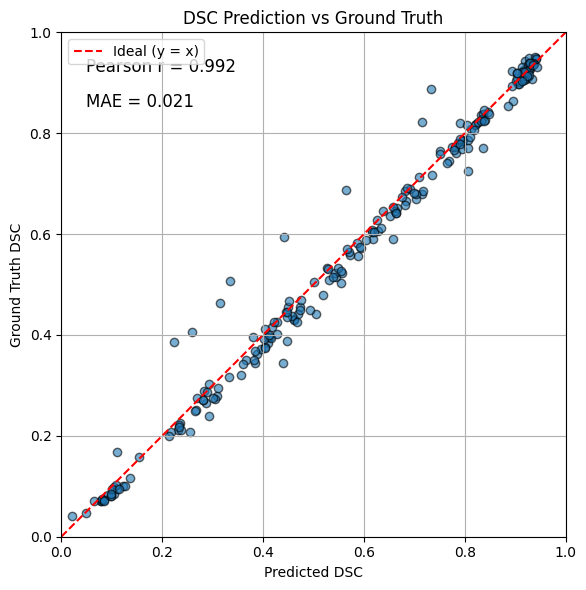

In [192]:
pred_dsc = predDSC3d 
gt_dsc = gtDSC3d
r, _ = pearsonr(pred_dsc, gt_dsc)

# Calculate Mean Absolute Error
mae = mean_absolute_error(gt_dsc, pred_dsc)

# Create scatter plot
plt.figure(figsize=(6, 6))
plt.scatter(pred_dsc, gt_dsc, alpha=0.6, edgecolors='k')
plt.plot([0, 1], [0, 1], 'r--', label='Ideal (y = x)')

# Add metrics as text in the plot
plt.text(0.05, 0.95, f"Pearson r = {r:.3f}", fontsize=12, verticalalignment='top')
plt.text(0.05, 0.88, f"MAE = {mae:.3f}", fontsize=12, verticalalignment='top')

# Labels and formatting
plt.xlabel('Predicted DSC')
plt.ylabel('Ground Truth DSC')
plt.title('DSC Prediction vs Ground Truth')
plt.grid(True)
plt.axis('square')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.legend()
plt.tight_layout()
plt.show()

### Accuracy

In [204]:
pred = np.array(predDSC3d)
gt = np.array(gtDSC3d)

# Threshold at 0.7
pred_bin = pred > 0.7
gt_bin = gt > 0.7

# Accuracy: number of times prediction and GT match
correct = pred_bin == gt_bin
accuracy = np.mean(correct)

print(f"Accuracy for threshold DSC > 0.7: {accuracy:.3f}")

Accuracy for threshold DSC > 0.7: 0.977


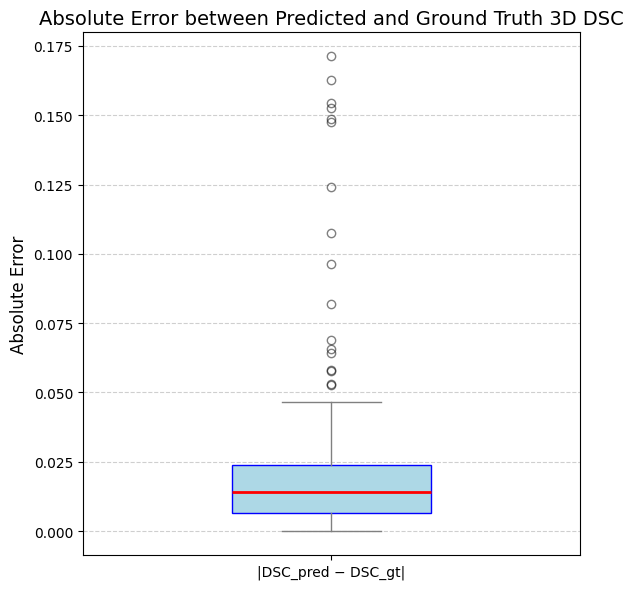

In [195]:
plt.figure(figsize=(6, 6))
plt.boxplot(np.abs(np.array(predDSC3d) - np.array(gtDSC3d)), widths=0.4, patch_artist=True,
            boxprops=dict(facecolor='lightblue', color='blue'),
            medianprops=dict(color='red', linewidth=2),
            whiskerprops=dict(color='gray'),
            capprops=dict(color='gray'),
            flierprops=dict(marker='o', color='gray', alpha=0.5))

plt.title("Absolute Error between Predicted and Ground Truth 3D DSC", fontsize=14)
plt.ylabel("Absolute Error", fontsize=12)
plt.xticks([1], ['|DSC_pred − DSC_gt|'])  # Single box, centered
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

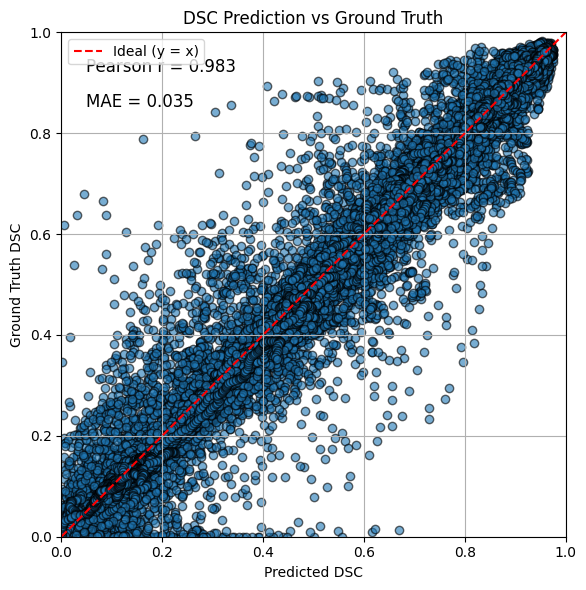

In [205]:
pred_dsc = df['preddsc']
gt_dsc = df['gtdsc']
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr
from sklearn.metrics import mean_absolute_error

# Example data (replace with your actual arrays)
# pred_dsc = ...
# gt_dsc = ...

# Calculate Pearson correlation coefficient
r, _ = pearsonr(pred_dsc, gt_dsc)

# Calculate Mean Absolute Error
mae = mean_absolute_error(gt_dsc, pred_dsc)

# Create scatter plot
plt.figure(figsize=(6, 6))
plt.scatter(pred_dsc, gt_dsc, alpha=0.6, edgecolors='k')
plt.plot([0, 1], [0, 1], 'r--', label='Ideal (y = x)')

# Add metrics as text in the plot
plt.text(0.05, 0.95, f"Pearson r = {r:.3f}", fontsize=12, verticalalignment='top')
plt.text(0.05, 0.88, f"MAE = {mae:.3f}", fontsize=12, verticalalignment='top')

# Labels and formatting
plt.xlabel('Predicted DSC')
plt.ylabel('Ground Truth DSC')
plt.title('DSC Prediction vs Ground Truth')
plt.grid(True)
plt.axis('square')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.legend()
plt.tight_layout()
plt.show()

In [206]:
pred = pred_dsc
gt = gt_dsc

# Threshold at 0.7
pred_bin = pred > 0.7
gt_bin = gt > 0.7

# Accuracy: number of times prediction and GT match
correct = pred_bin == gt_bin
accuracy = np.mean(correct)

print(f"Accuracy for threshold DSC > 0.7: {accuracy:.3f}")

Accuracy for threshold DSC > 0.7: 0.963


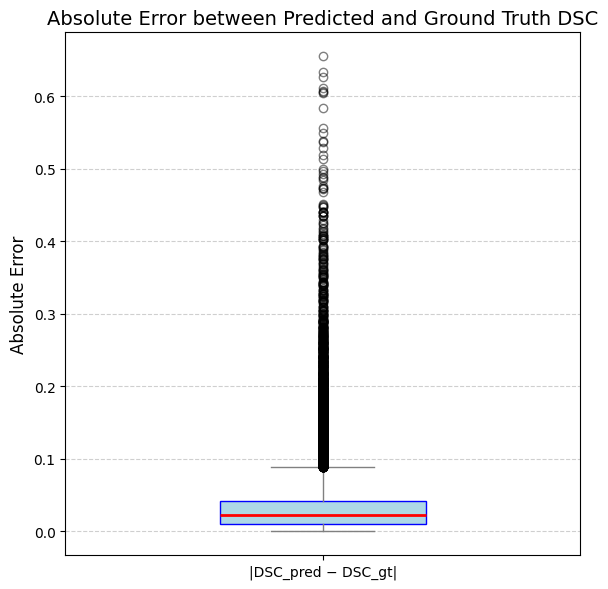

In [101]:
plt.figure(figsize=(6, 6))
plt.boxplot(np.abs(pred_dsc - gt_dsc), widths=0.4, patch_artist=True,
            boxprops=dict(facecolor='lightblue', color='blue'),
            medianprops=dict(color='red', linewidth=2),
            whiskerprops=dict(color='gray'),
            capprops=dict(color='gray'),
            flierprops=dict(marker='o', color='gray', alpha=0.5))

plt.title("Absolute Error between Predicted and Ground Truth DSC", fontsize=14)
plt.ylabel("Absolute Error", fontsize=12)
plt.xticks([1], ['|DSC_pred − DSC_gt|'])  # Single box, centered
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()